# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("data/stumbleupon/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 29 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  7395 non-null object
alchemy_category_score            7395 non-null object
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_r

In [3]:
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of &lt;embed&gt; usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an &lt;a&gt; with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of &lt;img&gt; tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 &lt;a&gt; 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer| Number of &lt;a&gt; markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [4]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

 >### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

>### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [5]:
# Option 1: Find out P ( evergreen | is_news = 1) vs P ( evergreen | is_news = ?)
data.groupby('is_news')['label'].mean()

is_news
1    0.516916
?    0.507562
Name: label, dtype: float64

In [6]:
pd.crosstab(data.is_news, data.label)

label,0,1
is_news,,
1,2199,2353
?,1400,1443


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


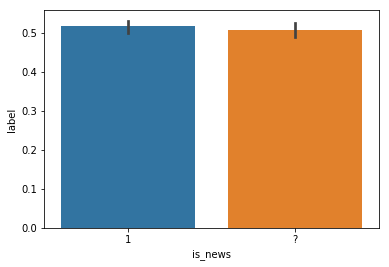

In [7]:
# Option 2: Plot in Seaborn
sns.barplot(x="is_news", y="label", data=data)
plt.show()

### Exercise: 4. Does category in general affect evergreeness? 
Compute and plot the rate of evergreen sites for all Alchemy categories.

In [8]:
data.groupby('alchemy_category')[['label']].mean().sort_values(by="label", ascending=False)

,label
alchemy_category,
business,0.711364
recreation,0.684296
health,0.573123
?,0.502135
culture_politics,0.457726
science_technology,0.456747
law_crime,0.419355
religion,0.416667
arts_entertainment,0.371945


In [9]:
category_order = data.groupby(['alchemy_category'])[['label']].mean().sort_values(by="label", ascending=False).index.values

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


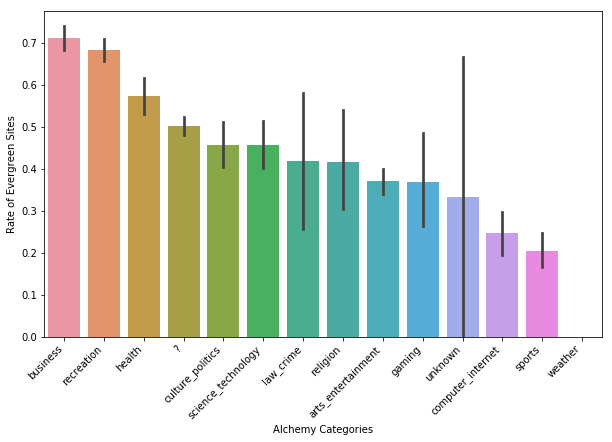

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x="alchemy_category", y="label", data=data, order=category_order)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel("Rate of Evergreen Sites")
plt.xlabel("Alchemy Categories")
plt.show()

### Exercise: 5. How many articles are there per category?

In [11]:
data.alchemy_category.value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


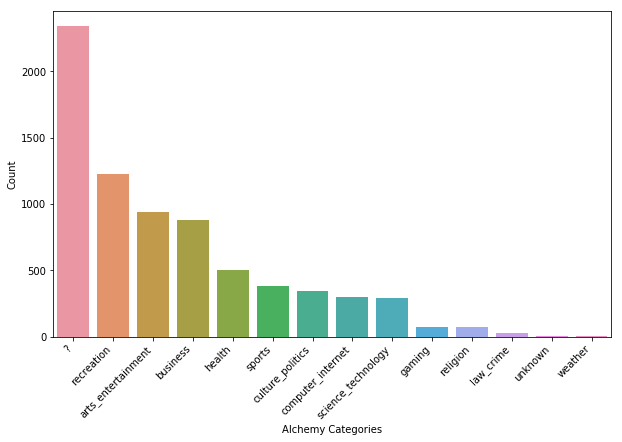

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(x="alchemy_category", y="label", data=data, estimator=len, order = data.alchemy_category.value_counts().index)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylabel("Count")
plt.xlabel("Alchemy Categories")
plt.show()

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evergreen websites higher or lower on pages that have recipe in the the title?

In [13]:
# Option 1: Create a function to check for this
def has_recipe(text_in):
    if text_in is None: 
        return 0
    elif 'recipe' in str(text_in).lower():
        return 1
    return 0
    
data['recipe'] = data['title'].apply(has_recipe)

In [14]:
# Option 2: Pandas Series string functions
data['recipe'] = data['title'].str.contains('recipe', case=False)

In [15]:
# Option 3: lambda functions
data['recipe'] = data['title'].apply(lambda t: 0 if t is None else 1 if 'recipe' in str(t).lower() else 0)

In [16]:
data.groupby(['recipe'])[['label']].mean()

,label
recipe,
0,0.455657
1,0.912206


### Gini Index

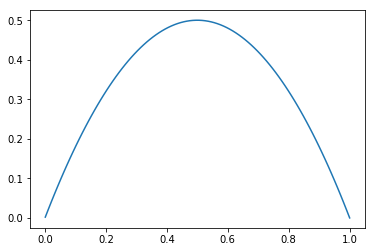

In [17]:
x = np.linspace(0.001,1,100)
y = x * (1-x) + (1-x) * x
plt.plot(x,y)
plt.show()

### Entropy 

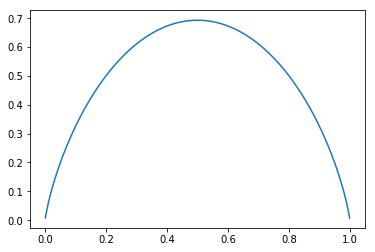

In [18]:
x = np.linspace(0.001,0.999,100)
y = -x * np.log(x) - (1-x) * np.log(1-x)
plt.plot(x,y)
plt.show()

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [19]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
# Fits the model
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    #dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file = "tree.dot", feature_names = X.columns)
    #dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.
 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.55339912 0.56834651 0.5891771  0.58543863 0.55550272], Average AUC 0.5703728148134432


In [22]:
scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV Accuracy [0.54864865 0.57606491 0.59364435 0.58282623 0.55751015], Average Accuracy 0.5717388588911699


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [23]:
model = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 5)
model.fit(X, y)
#build_tree_image(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.63031707 0.62042161 0.65810826 0.63402503 0.63001149], Average AUC 0.6345766909789823


In [25]:
scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV Accuracy [0.58445946 0.58147397 0.61189993 0.58823529 0.5879567 ], Average Accuracy 0.5908050706205249


In [26]:
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20, max_depth = 7)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.65003381 0.67175011 0.70030102 0.65894269 0.66252811], Average AUC 0.6687111456922871


### Demo: Extracting importance of features

In [29]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
2,recipe,0.512985
0,image_ratio,0.255630
1,html_ratio,0.231386


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [34]:
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 200, 10):
    model = RandomForestClassifier(n_estimators = n_trees, max_depth = 7)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [0.68971926 0.69857246 0.69428377], Average AUC 0.6941918326442647
n trees: 1, CV AUC [0.63938915 0.63133926 0.63138287], Average AUC 0.634037095377724
n trees: 11, CV AUC [0.68303416 0.69561693 0.68658401], Average AUC 0.6884117013128498
n trees: 21, CV AUC [0.68583202 0.69715942 0.69268824], Average AUC 0.6918932262198726
n trees: 31, CV AUC [0.68609334 0.70252767 0.6876155 ], Average AUC 0.6920788365404092
n trees: 41, CV AUC [0.68862296 0.70227899 0.69427784], Average AUC 0.6950599283962554
n trees: 51, CV AUC [0.68692009 0.69959124 0.69893323], Average AUC 0.6951481876229016
n trees: 61, CV AUC [0.68832774 0.69902866 0.69500242], Average AUC 0.6941196057925153
n trees: 71, CV AUC [0.68706194 0.69852899 0.69584931], Average AUC 0.6938134112968566
n trees: 81, CV AUC [0.69016588 0.69959289 0.69221848], Average AUC 0.6939924148722407
n trees: 91, CV AUC [0.69229825 0.70187582 0.69652774], Average AUC 0.69690060379683
n trees: 101, CV AUC [0.69008623 0.69736067 0.6985304 ], Ave

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [31]:
## 1. Building a model with more relevant features
model = RandomForestClassifier(n_estimators=50, max_depth=7)

# Continue to add features to X
# Build dummy features, include quantitative features, or add text features
X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

## 2a. Evaluate predictive performance for the given feature set
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.66516818 0.67839789 0.66209621], Average AUC 0.6685540952773413


In [32]:
# 3 (BONUS): Adding in text features
# Check for keywords in the title
data['PhotoInTitle'] = data['title'].fillna('').str.lower().str.contains('photo').astype(int)
X = data[['image_ratio', 'html_ratio', 'recipe', 'PhotoInTitle', 'numberOfLinks', 'spelling_errors_ratio', 'label']].dropna()
X.drop('label', axis=1, inplace=True)

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.69030082 0.70000165 0.69738781], Average AUC 0.6958967577075509


In [33]:
## 2b. Evaluating feature importances
# Fit a model on the whole dataset
model.fit(X, y)

# Get columns and their scores
features = X.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
2,recipe,0.452294
0,image_ratio,0.151659
5,spelling_errors_ratio,0.144823
4,numberOfLinks,0.133186
1,html_ratio,0.103500
3,PhotoInTitle,0.014539
